In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd

In [2]:
BANDS = {
    "дельта": "δ (дельта)",
    "тета": "θ (тета)",
    "альфа": "α (альфа)",
    "бета": "β (бета)",
    "гамма": "γ (гамма)"
}

In [3]:
def unite_rows(df, stage, string_replacements):
    df_filtered_separate = iv_isruc_s3[[col for col in df.columns if col.startswith(str(stage)) and col != f"{stage}_ALL"]]
    df_filtered_aggregated = iv_isruc_s3[f"{stage}_ALL"]

    if string_replacements is not None:
        df_filtered_separate.index = df_filtered_separate.index.str.replace(
            f"({'|'.join(string_replacements)})\s*", "", regex=True
        )
        df_filtered_aggregated.index = df_filtered_separate.index

    df_separate_as_lists = df_filtered_separate.apply(lambda row: row.tolist(), axis=1)
    df_separate_result = df_separate_as_lists.groupby(df_filtered_separate.index).apply(
        lambda rows: [item for row in rows for item in row]
    ).to_dict()

    df_aggregated_as_lists = df_filtered_aggregated.apply(lambda row: [row])
    df_aggregated_result = df_aggregated_as_lists.groupby(df_filtered_separate.index).apply(
        lambda rows: [item for row in rows for item in row]
    ).to_dict()

    return df_separate_result, df_aggregated_result

### ISRUC-Sleep

In [24]:
CHANNELS_ISRUC = ["F3", "C3", "O1", "F4", "C4", "O2"]
SLEEP_STAGES = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    5: "REM"
}

In [25]:
iv_isruc_s3 = pd.read_excel("iv/isruc-sleep/results_s3_bu.xlsx", index_col=0)

In [26]:
filter = "мера"

for epoch in [0, 1, 2, 3, 5]:
    print("EPOCH", epoch)
    filtered = iv_isruc_s3.loc[
        np.char.find(np.array(iv_isruc_s3.index, dtype="str"), filter) != -1
    ]
    print("Крайне сильная:", sum(filtered[f"{epoch}_ALL"] >= 1))
    print("Сильн. + кр.с.:", sum(filtered[f"{epoch}_ALL"] >= 0.6))
    print("Всего:", len(filtered[f"{epoch}_ALL"]), "\n")


EPOCH 0
Крайне сильная: 21
Сильн. + кр.с.: 84
Всего: 240 

EPOCH 1
Крайне сильная: 11
Сильн. + кр.с.: 20
Всего: 240 

EPOCH 2
Крайне сильная: 9
Сильн. + кр.с.: 32
Всего: 240 

EPOCH 3
Крайне сильная: 29
Сильн. + кр.с.: 78
Всего: 240 

EPOCH 5
Крайне сильная: 11
Сильн. + кр.с.: 38
Всего: 240 



In [163]:
filter = "[отн-е PSD]"

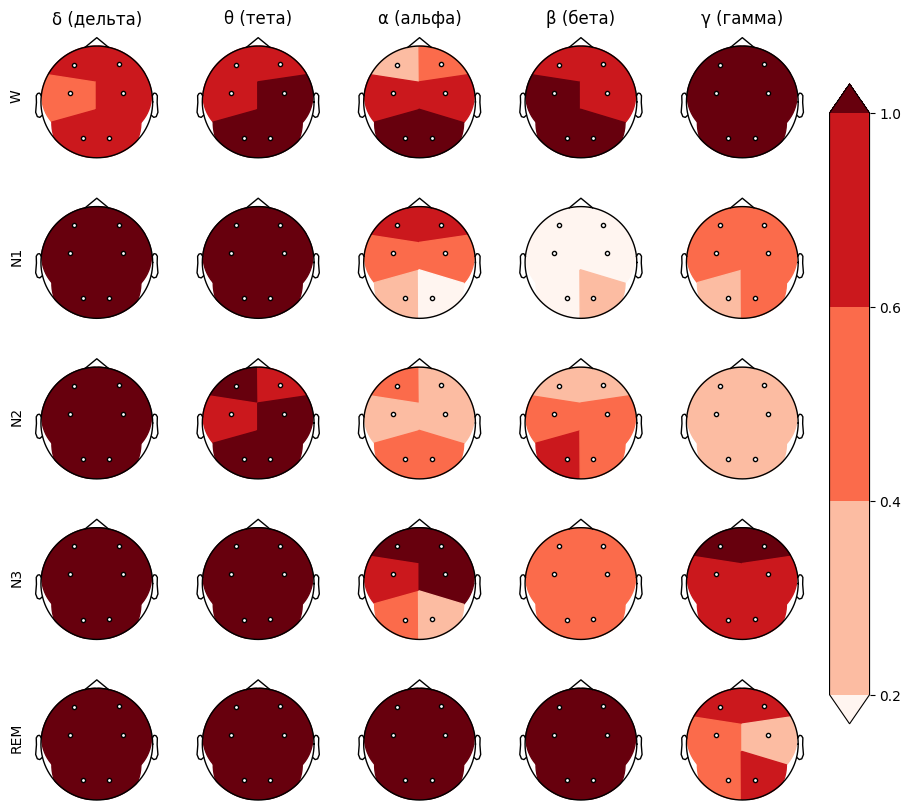

In [115]:
mpl.rc("text", usetex=False)

info = mne.create_info(CHANNELS_ISRUC, 200, ch_types="eeg").set_montage("standard_1020")
fig, ax = plt.subplots(5, 5, figsize=(10, 8))

bounds = [0.2, 0.4, 0.6, 1]
cmap = plt.get_cmap("Reds")
cnorm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=3)

for sleep_stage_i, (sleep_stage_num, sleep_stage_name) in enumerate(SLEEP_STAGES.items()):
    isruc_s3_sep, isruc_s3_agg = unite_rows(
        iv_isruc_s3,
        stage=sleep_stage_num,
        string_replacements=None
    )
    for band_i, (band_orig, band_full_name) in enumerate(BANDS.items()):
        topo_values = []
        for channel in CHANNELS_ISRUC:
            topo_values.append(
                np.array(isruc_s3_agg[f"{filter} {channel} {band_orig}"]).mean()
            )
        im, cm = mne.viz.plot_topomap(
            topo_values, info,
            # vlim=(0, 4),
            axes=ax[sleep_stage_i][band_i],
            cmap=cmap,
            cnorm=cnorm,
            mask=np.array([True] * 6),
            mask_params=mask_params,
            contours=False,
            image_interp="nearest",
            show=False,
        )
        ax[0][band_i].set_title(band_full_name)

        ax[sleep_stage_i][0].set_ylabel(sleep_stage_name)

ax_x_start = 0.91
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.8
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
plt.subplots_adjust(left=0.11, right=0.89, top=0.97, bottom=0)
plt.savefig(f"plots/isruc-sleep/{filter}_heads.png")
plt.show()

In [187]:
stage = 5

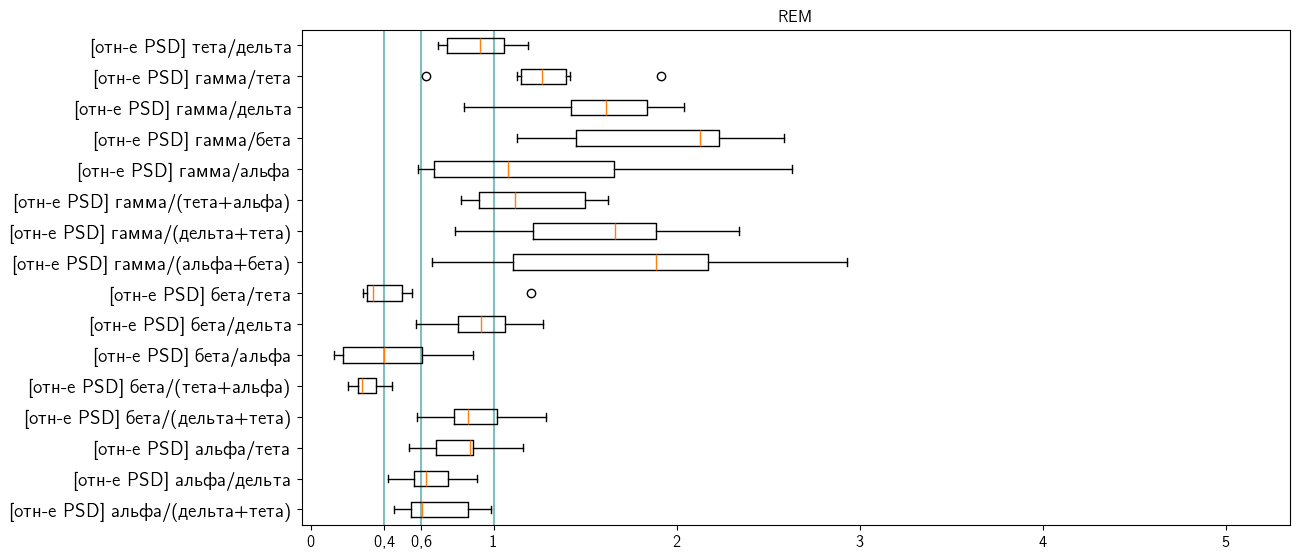

In [188]:
isruc_s3_sep, isruc_s3_agg = unite_rows(
    iv_isruc_s3,
    stage=stage,
    string_replacements=CHANNELS_ISRUC
)

filtered_data = {k: v for k, v in isruc_s3_agg.items() if filter in k}

mpl.rc("text", usetex=True)
mpl.rcParams["text.latex.preamble"] = r"\usepackage[utf8]{inputenc} \usepackage[russian]{babel}"
# mpl.rcParams["font.family"] = "monospace"

fig, ax = plt.subplots(figsize=(13, 5.5))
ax.axvline(x = 0.4, color = "teal", alpha=0.5)
ax.axvline(x = 0.6, color = "teal", alpha=0.5)
ax.axvline(x = 1, color = "teal", alpha=0.5)
ax.boxplot(
    list(filtered_data.values()),
    vert=False
)
# ax.set_yticklabels(y_tick_labels[:18], fontsize=14)
ax.set_yticklabels(filtered_data.keys(), fontsize=14)
ax.set_xticks([0, 0.4, 0.6, 1, 2, 3, 4, 5])
ax.set_xticklabels([0, "0,4", "0,6", 1, 2, 3, 4, 5], fontsize=12)
ax.set_title(SLEEP_STAGES[stage])
plt.subplots_adjust(left=0.23, right=0.99, top=0.95, bottom=0.05)
plt.xlim(-0.05, 5.35)
plt.savefig(f"plots/isruc-sleep/{filter}_boxplot_st{stage}")

In [161]:
stage = 5

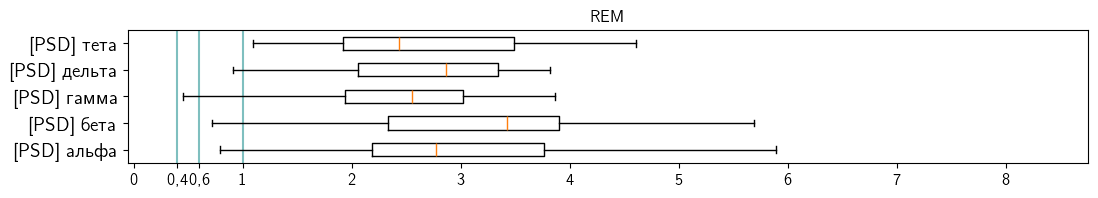

In [162]:
isruc_s3_sep, isruc_s3_agg = unite_rows(
    iv_isruc_s3,
    stage=stage,
    string_replacements=CHANNELS_ISRUC
)

filtered_data = {k: v for k, v in isruc_s3_sep.items() if filter in k}

mpl.rc("text", usetex=True)
mpl.rcParams["text.latex.preamble"] = r"\usepackage[utf8]{inputenc} \usepackage[russian]{babel}"
# mpl.rcParams["font.family"] = "monospace"

fig, ax = plt.subplots(figsize=(12, 1.9))
ax.axvline(x = 0.4, color = "teal", alpha=0.5)
ax.axvline(x = 0.6, color = "teal", alpha=0.5)
ax.axvline(x = 1, color = "teal", alpha=0.5)
ax.boxplot(
    list(filtered_data.values()),
    vert=False
)
# ax.set_yticklabels(y_tick_labels[:18], fontsize=14)
ax.set_yticklabels(filtered_data.keys(), fontsize=14)
ax.set_xticks([0, 0.4, 0.6, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xticklabels([0, "0,4", "0,6", 1, 2, 3, 4, 5, 6, 7, 8], fontsize=12)
ax.set_title(SLEEP_STAGES[stage])
plt.subplots_adjust(left=0.15, right=0.95, top=0.85, bottom=0.15)
plt.xlim(-0.05, 8.75)
plt.savefig(f"plots/isruc-sleep/{filter}_boxplot_sep_st{stage}")